In [1]:
import stlearn as st
st.settings.set_figure_params(dpi=120)
import warnings
warnings.filterwarnings('ignore')

## Prepare data

In [2]:
data = st.Read10X(path="/home/d.pham/10X/TBI_C1/")
data.var_names_make_unique()
tmp = data[:,["Fcrls","Tmem119"]].to_df()
microglia_spots = tmp.sum(axis=1)[tmp.sum(axis=1)>1].index

In [3]:
import pandas as pd
# Setup list of related and marker genes
upgenes= list(pd.read_table("/home/d.pham/Downloads/up1000.txt",header=None)[0])
downgnees = list(pd.read_table("/home/d.pham/Downloads/down1000.txt",header=None)[0])
merged_upgenes = []
for gene in upgenes:
    if gene in data.var_names:
        merged_upgenes.append(gene)
merged_downgenes = []
for gene in downgnees:
    if gene in data.var_names:
        merged_downgenes.append(gene)
merged_upgenes.append("Fcrls")
merged_upgenes.append("Tmem119")

In [4]:
pd.DataFrame(merged_upgenes + merged_downgenes).to_csv("list_gene.csv")

## Preprocessing

In [5]:
import scanpy as sc
sc.pp.filter_cells(data, min_genes=200)
sc.pp.filter_genes(data, min_cells=3)
data.var['mt'] = data.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(data, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
data = data[:,list(set(merged_upgenes+merged_downgenes) & set(data.var_names))]
data = data[data.obs.n_genes_by_counts < 7500, :]


In [6]:
data.raw = data

In [7]:
st.pp.normalize_total(data)
st.pp.log1p(data)

sc.pp.highly_variable_genes(data, min_mean=0.0025, max_mean=3, min_disp=0.5)
data = data[:, data.var.highly_variable]
st.pp.scale(data, max_value=10)


Normalization step is finished in adata.X
Log transformation step is finished in adata.X
Scale step is finished in adata.X


# Run stSME

In [8]:
st.em.run_pca(data,n_comps=25,random_state=0)

st.pp.tiling(data,out_path="../tiling",crop_size = data.uns["spatial"]["Visium_LP4_map_C1"]["scalefactors"]["spot_diameter_fullres"])
st.pp.extract_feature(data)
st.spatial.morphology.adjust(data,use_data="X_pca",radius=40,method="mean")

Tiling image:   5%|▌          [ time left: 00:01 ]

PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']


Tiling image: 100%|██████████ [ time left: 00:00 ]
Extract feature: 100%|██████████ [ time left: 00:00 ]
Adjusting data:   3%|▎          [ time left: 00:03 ]

The morphology feature is added to adata.obsm['X_morphology']!


Adjusting data: 100%|██████████ [ time left: 00:00 ]

The data adjusted by morphology is added to adata.obsm['X_pca_morphology']


Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 


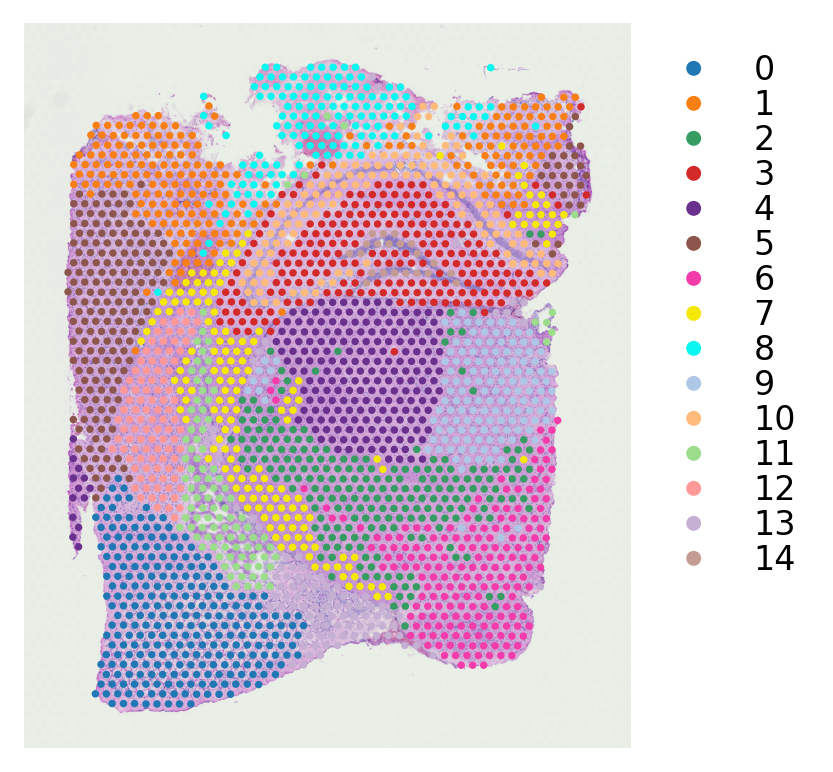

In [9]:
st.settings.set_figure_params(dpi=120)
st.pp.neighbors(data,n_neighbors=25,use_rep='X_pca',random_state=0)
sc.tl.leiden(data,resolution=1,random_state=0)
st.settings.set_figure_params(dpi=120)
st.pl.cluster_plot(data,use_label="leiden")

In [10]:
# data.obs["leiden"].to_csv("tbi_c_cluster.csv")

## Initialize PSTS

In [11]:
import numpy as np
# Choose root at the edge of cluster 1 (damaged sites)
data.uns["iroot"] = st.spatial.trajectory.set_root(data,use_label="leiden",cluster="1",use_raw=True)
st.spatial.trajectory.pseudotime(data,eps=100,use_label="leiden",threshold_spots=15,use_sme=False,use_rep="X_pca",reverse=True)

All available trajectory paths are stored in adata.uns['available_paths'] with length < 4 nodes


In [12]:
# Filter spots
micro_spot_filter = []
for ind in microglia_spots:
    if ind in data.obs_names:
        micro_spot_filter.append(ind)

data = data[micro_spot_filter]

In [13]:
from anndata import AnnData
from typing import Optional, Union
import numpy as np
import pandas as pd
import networkx as nx
from scipy.spatial.distance import cdist
import scanpy

def generate_graph_without_localization(adata,use_label: str = None,
    eps: float = 20,n_neighbors: int = 25,
    use_rep: str = "X_pca",
    threshold: float = 0.01,
    radius: int = 50,
    method: str = "mean",
    threshold_spots: int = 5,
    use_sme: bool = False,
    reverse: bool = False,
    pseudotime_key: str = "dpt_pseudotime",
    max_nodes: int = 4,
    run_knn: bool = False,
    copy: bool = False,):
    # Get connection matrix
    cnt_matrix = adata.uns["paga"]["connectivities"].toarray()

    # Filter by threshold

    cnt_matrix[cnt_matrix < threshold] = 0.0
    cnt_matrix = pd.DataFrame(cnt_matrix)

    # Mapping louvain label to subcluster

    cat_ind = adata.uns[use_label + "_index_dict"]

    split_node = {}
    for label in adata.obs[use_label].unique():
        meaningful_sub = []
        for i in adata.obs[adata.obs[use_label] == label][
            "sub_cluster_labels"
        ].unique():
            if (
                len(adata.obs[adata.obs["sub_cluster_labels"] == str(i)])
                > threshold_spots
            ):
                meaningful_sub.append(i)

        split_node[cat_ind[label]] = meaningful_sub

    adata.uns["threshold_spots"] = threshold_spots
    adata.uns["split_node"] = split_node

    # Replicate louvain label row to prepare for subcluster connection
    # matrix construction
    replicate_list = np.array([])
    for i in range(0, len(cnt_matrix)):
        replicate_list = np.concatenate(
            [replicate_list, np.array([i] * len(split_node[i]))]
        )

    # Connection matrix for subcluster
    cnt_matrix = cnt_matrix.loc[replicate_list.astype(int), replicate_list.astype(int)]

    # Replace column and index
    cnt_matrix.columns = replace_with_dict(cnt_matrix.columns, split_node)
    cnt_matrix.index = replace_with_dict(cnt_matrix.index, split_node)

    # Sort column and index
    cnt_matrix = cnt_matrix.loc[
        selection_sort(np.array(cnt_matrix.columns)),
        selection_sort(np.array(cnt_matrix.index)),
    ]

    # Create a connection graph of subclusters
    G = nx.from_pandas_adjacency(cnt_matrix)
    G_nodes = list(range(len(G.nodes)))

    node_convert = {}
    for pair in zip(list(G.nodes), G_nodes):
        node_convert[pair[1]] = pair[0]

    adata.uns["global_graph"] = {}
    adata.uns["global_graph"]["graph"] = nx.to_scipy_sparse_array(G)
    adata.uns["global_graph"]["node_dict"] = node_convert

    # Create centroid dict for subclusters
    from sklearn.neighbors import NearestCentroid

    clf = NearestCentroid()
    clf.fit(adata.obs[["imagecol", "imagerow"]].values, adata.obs["sub_cluster_labels"])
    centroid_dict = dict(zip(clf.classes_.astype(int), clf.centroids_))

    def closest_node(node, nodes):
        nodes = np.asarray(nodes)
        dist_2 = np.sum((nodes - node) ** 2, axis=1)
        return np.argmin(dist_2)

    for cl in adata.obs["sub_cluster_labels"].unique():
        cl_points = adata.obs[adata.obs["sub_cluster_labels"] == cl][
            ["imagecol", "imagerow"]
        ].values
        new_centroid = cl_points[closest_node(centroid_dict[int(cl)], cl_points)]
        centroid_dict[int(cl)] = new_centroid

    adata.uns["centroid_dict"] = centroid_dict
    centroid_dict = {int(key): centroid_dict[key] for key in centroid_dict}
    
def replace_with_dict(ar, dic):
    # Extract out keys and values
    k = np.array(list(dic.keys()), dtype=object)
    v = np.array(list(dic.values()), dtype=object)

    out = np.zeros_like(ar)
    for key, val in zip(k, v):
        out[ar == key] = val
    return out


def selection_sort(x):
    for i in range(len(x)):
        swap = i + np.argmin(x[i:])
        (x[i], x[swap]) = (x[swap], x[i])
    return x


def store_available_paths(adata, threshold, use_label, max_nodes, pseudotime_key):

    # Read original PAGA graph
    G = nx.from_numpy_array(adata.uns["paga"]["connectivities"].toarray())
    edge_weights = nx.get_edge_attributes(G, "weight")
    G.remove_edges_from((e for e, w in edge_weights.items() if w < threshold))

    H = G.to_directed()

    # Calculate pseudotime for each node
    node_pseudotime = {}

    for node in H.nodes:
        node_pseudotime[node] = adata.obs.query(use_label + " == '" + str(node) + "'")[
            pseudotime_key
        ].max()

    # Force original PAGA to directed PAGA based on pseudotime
    edge_to_remove = []
    for edge in H.edges:
        if node_pseudotime[edge[0]] - node_pseudotime[edge[1]] > 0:
            edge_to_remove.append(edge)
    H.remove_edges_from(edge_to_remove)

    # Extract all available paths
    all_paths = {}

    for source in H.nodes:
        for target in H.nodes:
            paths = nx.all_simple_paths(H, source=source, target=target)
            for i, path in enumerate(paths):
                if len(path) < max_nodes:
                    all_paths[i] = path

    # all_paths = list(map(lambda x: " - ".join(np.array(x).astype(str)),all_paths))

    adata.uns["available_paths"] = all_paths
    print(
        "All available trajectory paths are stored in adata.uns['available_paths'] with length < "
        + str(max_nodes)
        + " nodes"
    )


## Variogram and trajectory reconstruction

In [14]:
from skgstat import Variogram
from sklearn.preprocessing import MinMaxScaler

### Monocle3

In [15]:
monocle3 = pd.read_csv("monocle3_pseudotime.csv")
data.obs["dpt_pseudotime"] = list(monocle3.set_index("Unnamed: 0").loc[data.obs_names]["pseudotime(cds)"])

scaler = MinMaxScaler()
scaler.fit(np.array(data.obs["dpt_pseudotime"]).reshape(-1, 1))

data.obs["dpt_pseudotime"] = scaler.transform(np.array(data.obs["dpt_pseudotime"]).reshape(-1, 1)).reshape(1, -1)[0]
data.obs["dpt_pseudotime"] = 1 - data.obs["dpt_pseudotime"]



In [16]:
# Remove the localization by PSTS
data.obs["sub_cluster_labels"] = data.obs["leiden"].values
generate_graph_without_localization(data,use_label="leiden")

In [17]:
st.spatial.trajectory.pseudotimespace_global(data,use_label="leiden",list_clusters=["1","3","4","6"],)

Start to construct the trajectory: 6 -> 4 -> 3 -> 1


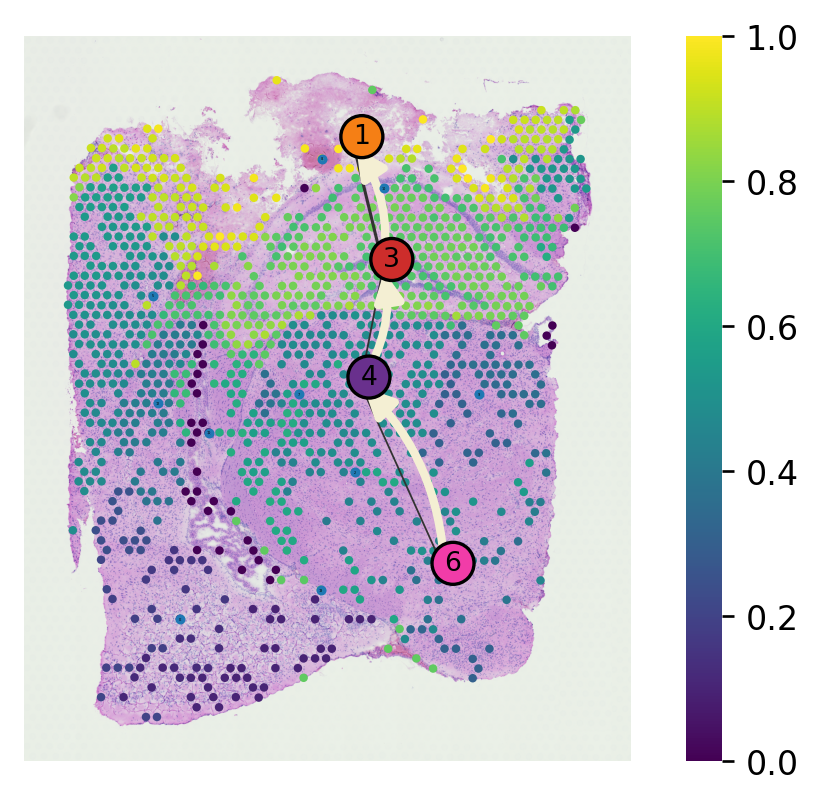

In [18]:
st.pl.trajectory.pseudotime_plot(data,use_label="leiden",list_clusters=["1","3","4","6"],show_graph=True, pseudotime_key="dpt_pseudotime",
                                 edge_alpha=1.0,node_size=7,show_trajectories=True)

In [19]:
V_mor = Variogram(coordinates=data.obs[["imagecol","imagerow"]].values, values=data.obs["dpt_pseudotime"].values,
            model='gaussian')

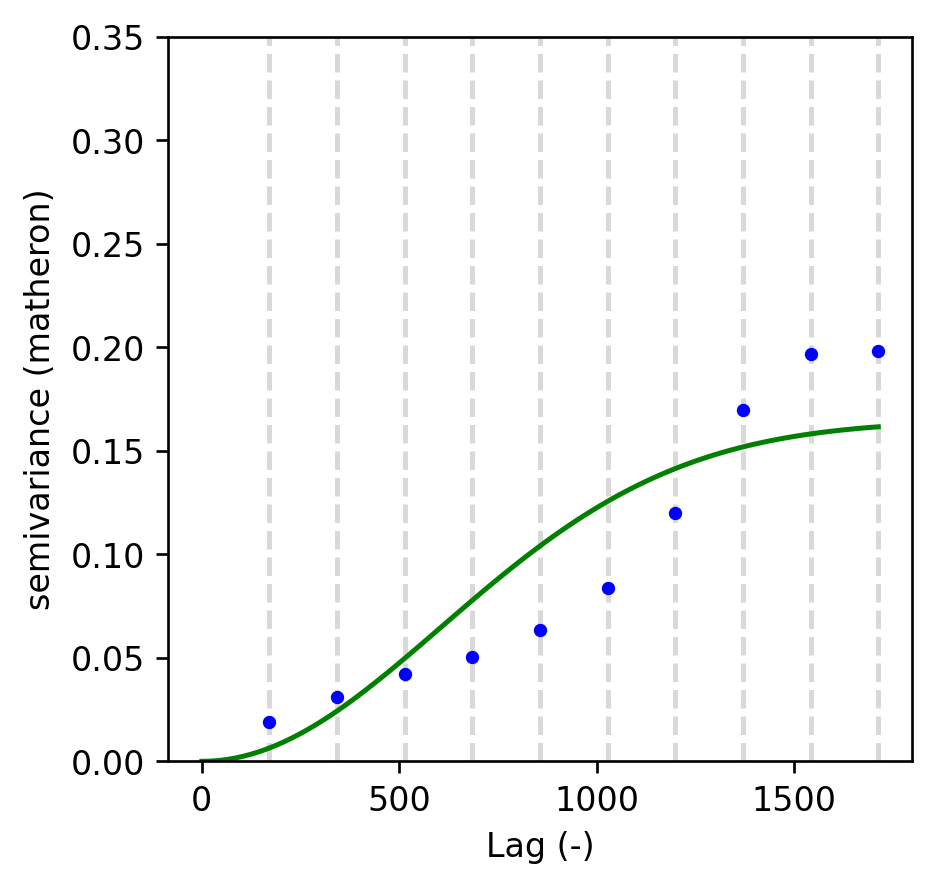

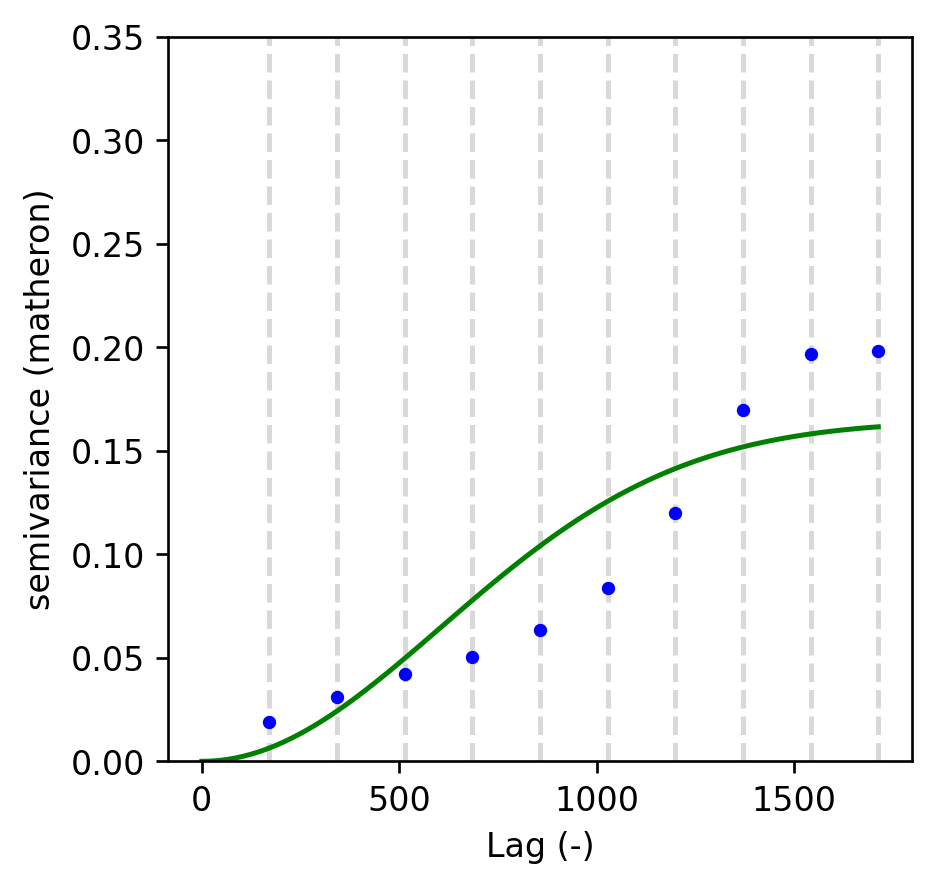

In [20]:
import matplotlib.pyplot as plt
fig, a = plt.subplots(figsize=(4,4))
a.set_ylim(0,0.35)
V_mor.plot(hist=False,axes=a)

### Slingshot

In [22]:
slingshot = pd.read_csv("slingshot_pst_1.csv")

In [23]:
data.obs["dpt_pseudotime"] = list(slingshot.set_index("Unnamed: 0").loc[data.obs_names]["slingPseudotime_2"])

scaler = MinMaxScaler()
scaler.fit(np.array(data.obs["dpt_pseudotime"]).reshape(-1, 1))

data.obs["dpt_pseudotime"] = scaler.transform(np.array(data.obs["dpt_pseudotime"]).reshape(-1, 1)).reshape(1, -1)[0]
data.obs["dpt_pseudotime"] = 1 - data.obs["dpt_pseudotime"]


In [24]:
# Remove the localization by PSTS
data.obs["sub_cluster_labels"] = data.obs["leiden"].values
generate_graph_without_localization(data,use_label="leiden")

In [25]:
st.spatial.trajectory.pseudotimespace_global(data,use_label="leiden",list_clusters=["1","3","4","6"],)

Start to construct the trajectory: 6 -> 4 -> 3 -> 1


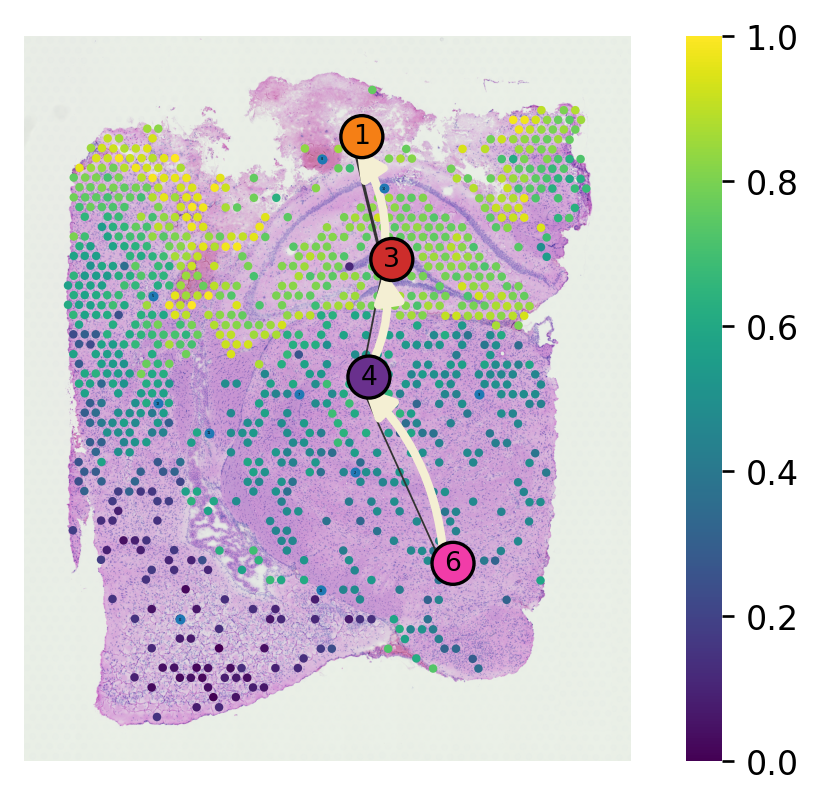

In [26]:
st.pl.trajectory.pseudotime_plot(data,use_label="leiden",list_clusters=["1","3","4","6"],show_graph=True, pseudotime_key="dpt_pseudotime",
                                 edge_alpha=1.0,node_size=7,show_trajectories=True)

In [27]:
# Remove NA
tmp = data.obs.copy()
tmp = tmp.dropna()

In [28]:
V_mor = Variogram(coordinates=tmp[["imagecol","imagerow"]].values, values=tmp["dpt_pseudotime"].values,
            model='gaussian')

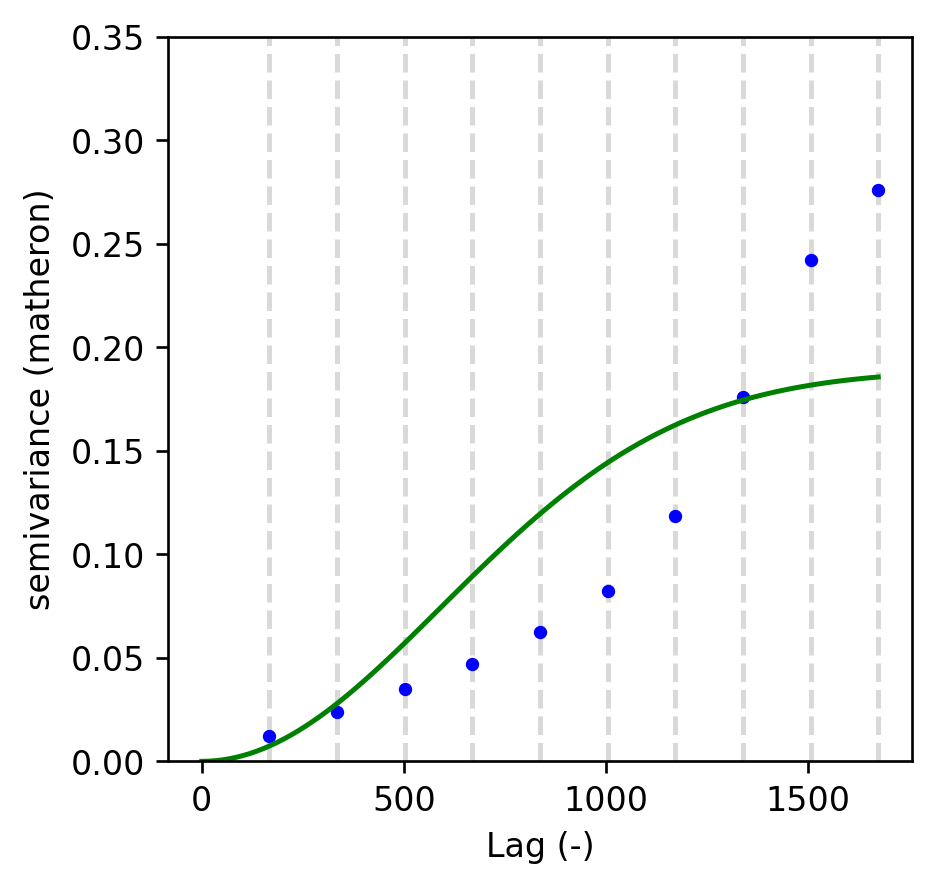

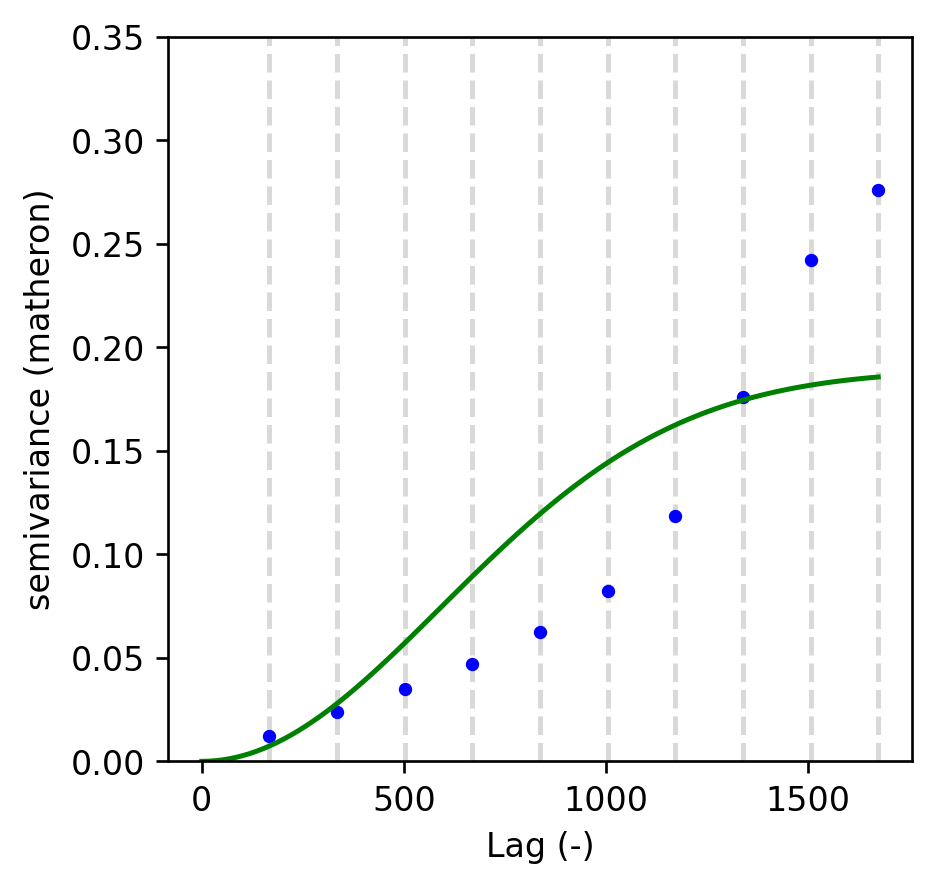

In [29]:
import matplotlib.pyplot as plt
fig, a = plt.subplots(figsize=(4,4))
a.set_ylim(0,0.35)
V_mor.plot(hist=False,axes=a)

### SpaceFlow

In [31]:
spaceflow = pd.read_csv("pSM_values.tsv",header=None)

In [32]:
data.obs["dpt_pseudotime"] = spaceflow[0].values

scaler = MinMaxScaler()
scaler.fit(np.array(data.obs["dpt_pseudotime"]).reshape(-1, 1))

data.obs["dpt_pseudotime"] = scaler.transform(np.array(data.obs["dpt_pseudotime"]).reshape(-1, 1)).reshape(1, -1)[0]
# data.obs["dpt_pseudotime"] = 1 - data.obs["dpt_pseudotime"]


In [33]:
# Remove the localization by PSTS
data.obs["sub_cluster_labels"] = data.obs["leiden"].values
generate_graph_without_localization(data,use_label="leiden")

In [34]:
st.spatial.trajectory.pseudotimespace_global(data,use_label="leiden",list_clusters=["1","3","4","6"],)

Start to construct the trajectory: 3 -> 1 -> 6 -> 4


ValueError: The chosen clusters are not available to construct the spatial trajectory! Please choose other path.

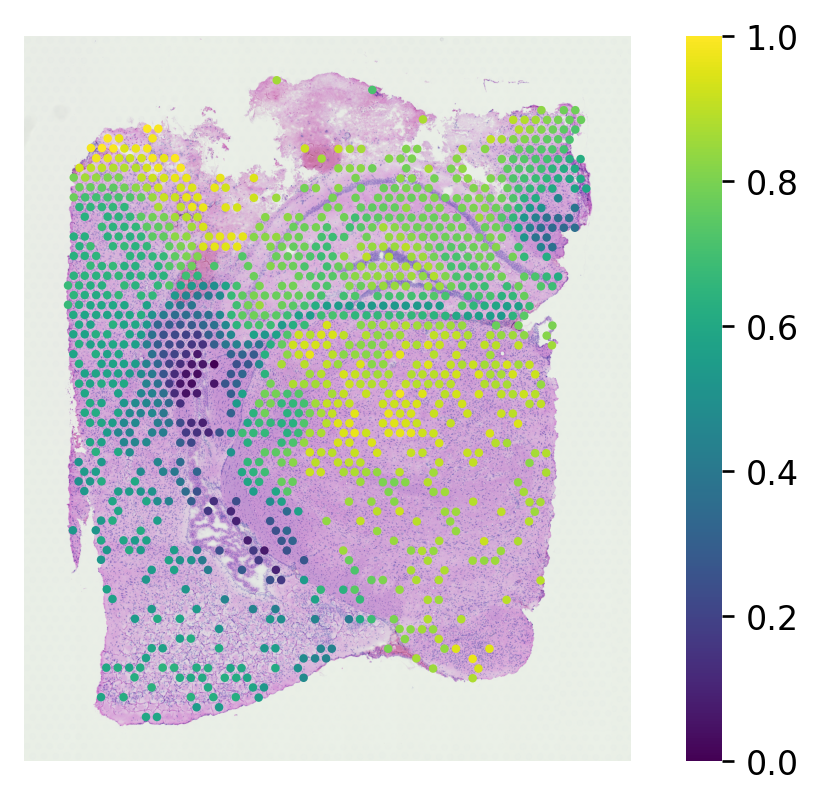

In [35]:
st.pl.trajectory.pseudotime_plot(data,use_label="leiden",list_clusters=["1","3","4","6"], pseudotime_key="dpt_pseudotime",
                                 edge_alpha=1.0,node_size=7,show_graph=False)

In [36]:
V_mor = Variogram(coordinates=data.obs[["imagecol","imagerow"]].values, values=data.obs["dpt_pseudotime"].values,
            model='gaussian')

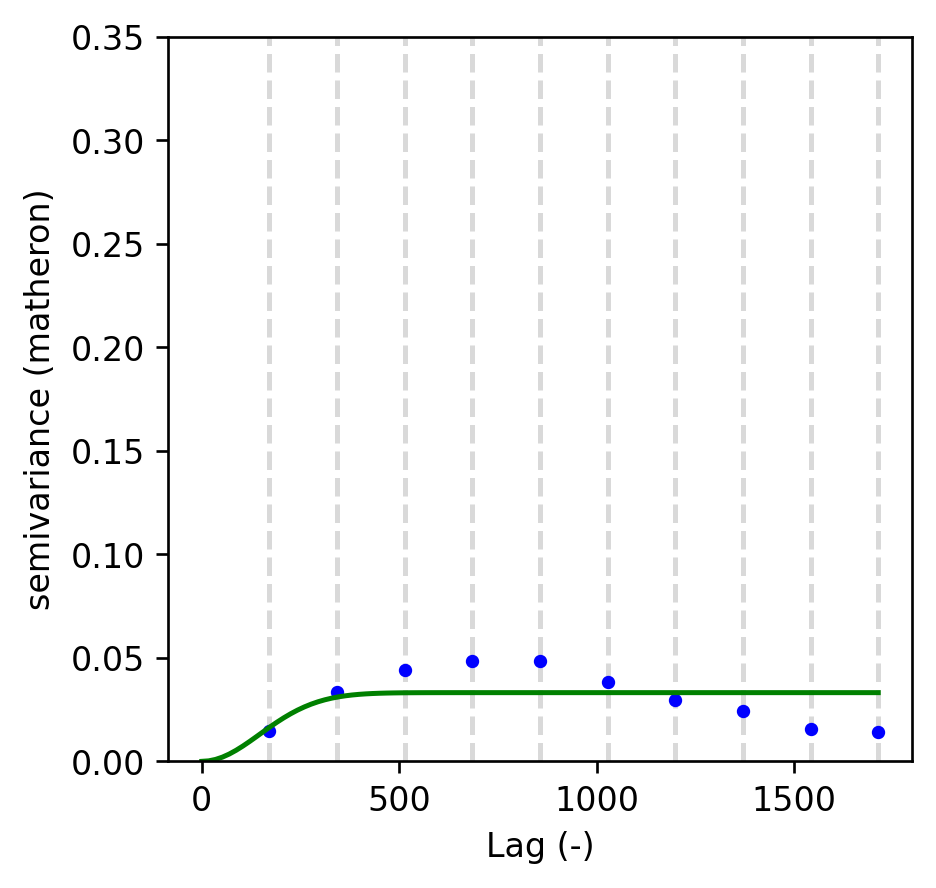

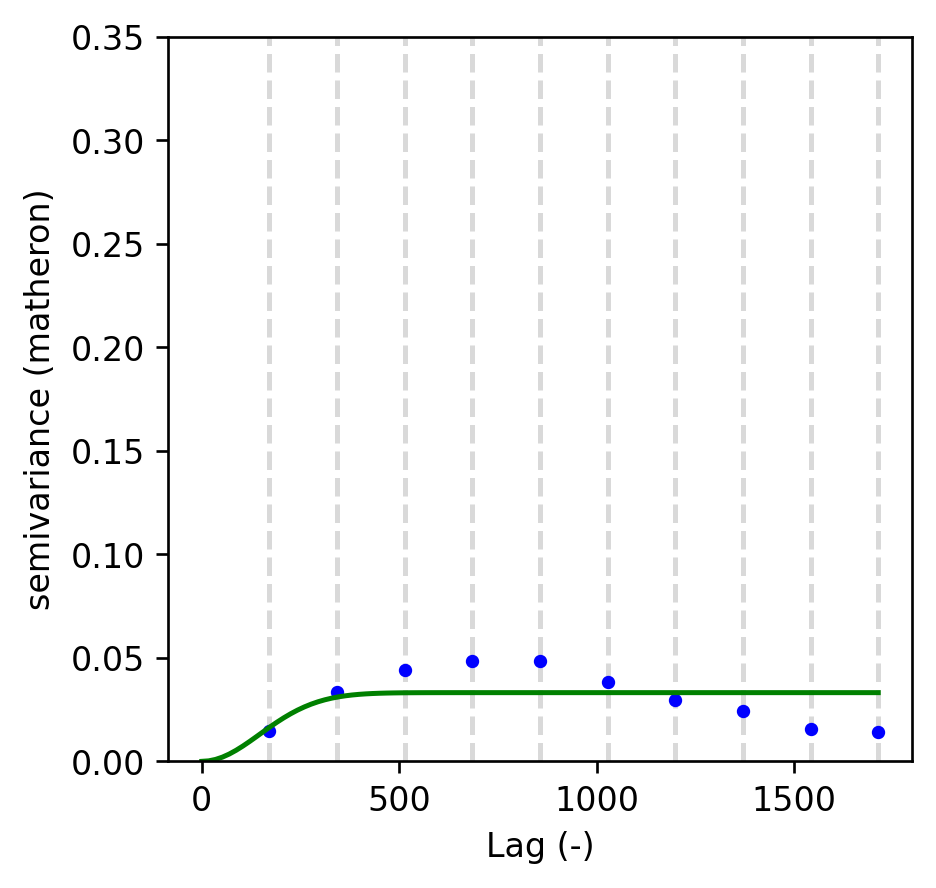

In [37]:
import matplotlib.pyplot as plt
fig, a = plt.subplots(figsize=(4,4))
a.set_ylim(0,0.35)
V_mor.plot(hist=False,axes=a)